In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
from scipy import optimize as opti
import os
from IPython.display import display
from numpy import exp
from datetime import datetime as dt

plt.style.use({'figure.facecolor':'white'})
def sgy(y, window_size, order, deriv=0, rate=1):

    
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        window_size=window_size+1
        #raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [2]:
#method for selecting measurementfiles out of the datafolder
def gather_measurements(path: str) -> list:
    subdir=path
    fileex='.erg'
    data={}
    for locpath, subdirs, files in os.walk(subdir):
        for name in files:
            if name.endswith(fileex) and name[-8]=='W' : 
                
                b=(str(os.path.join(path, name)))
                f=get_name(name)
                data[f]=b

                #print (str(os.path.join(path, name)))
    return data
#method to find files based on a specific string at the beginning of the name
def gather_files(path: str,filetype: str)-> list:
    subdir=path

    data=[]
    for path, subdirs, files in os.walk(subdir):
        for name in files:
            if name.split('_')[-1].startswith(filetype)  : 
                
                b=(str(os.path.join(path, name)))
                data.append(b)

                #print (str(os.path.join(path, name)))
    return data
#universal file gathering function based on fileextensions
def gather_universal(path: str,filetype: str)-> list:
    subdir=path

    data=[]
    for path, subdirs, files in os.walk(subdir):
        for name in files:
            if name.endswith(filetype)  : 
                
                b=(str(os.path.join(path, name)))
                data.append(b)

                #print (str(os.path.join(path, name)))
    return data
#extracts the needed base measurements out of the bases dictionary depending on their type
def get_blindbase(bases: dict,typ: str) -> dict:
    data=bases[str(typ[0]+'B')]
    #display(data)
    res=pd.DataFrame()
    res['SAMPLE']=['m','t']
    for curve in data:
        
        res[curve.name]=np.polyfit(curve.roundtemperature,curve.smoothsignal,1) #Linearer fit an Messdaten von Basismessung Extraktion von Steigung und Achsenabschnitt
        

    res.drop('SAMPLE',axis=1,inplace=True)

    mean_slope=res.iloc[0,:].mean() #Mitteln von Steigung und Achsenabschnitt aller Basislinien
    mean_step=res.iloc[1,:].mean()
    temp=np.arange(10,1000,1)
    base=(temp*mean_slope)+mean_step
    #display(temp,base)
    return dict(zip(temp,base))
#takes mostly temp vecctors and determines the common overlap
def get_overlap(*args: list) -> np.ndarray:
    lengths=[len(i) for i in args[0] ]
    firsts=[ min(i) for i in args[0]]    
    lasts=[ max(i) for i in args[0]]
    first=max(firsts)
    last=min(lasts)
    return np.arange(first,last+1,1).astype(int)
#extracts name out of path
def get_name(path: str) -> str:
    name=path.split('_')[-1].split('.')[0]
    return name
#extracts type out of a path
def get_type(name: str)-> str:
    return name[0]+name[2]
#merges a zip of a temp and a datavector on to the given new tempvector(rtempvector)
def merger(rtempvector: np.ndarray,listoftempdatazip: list) -> dict:
    merge=pd.DataFrame(index=rtempvector)
    datas=[pd.DataFrame.from_dict(i,orient='index') for i in listoftempdatazip ]
    for df in datas:
        merge=merge.join(df,lsuffix= 'old',rsuffix='new')

    merge.fillna(0,inplace=True)
    mergeresult=merge.mean(axis=1).to_dict()
    return mergeresult
#method for stretching PPMS signal of a averaged material to any length temperaturevector
def matppms_lookup(typ: str) ->dict:
    res=dict(zip(mmaterials[typ].roundtemperature,mmaterials[typ].ppms))
    return res
#method for loading .erg files from datafolder
def load (inputpath:str) -> pd.DataFrame:#gibt die temparatur als dataframe und das rohsignal als Dataframe zurück sowie Konstanten aus dem Ende der Datei
    
    #outputpath=inputpath.split('.')[0]+'_out'+'.xlsx'
    df=pd.read_csv(inputpath)

    cc=float((str(df.iloc[-7:-6,0])).split(' ')[5].split('\n')[0])#Kalibrationskonstante
    ap=float(((str(df.iloc[-3:-2,0]).split(' ')[5]).split('\n'))[0])#Anpassung
    w=float(((str(df.iloc[-32:-31,0]).split(' ')[5]).split('\n'))[0]) #Einwaage
    t=float(((str(df.iloc[-33:-32,0]).split(' ')[5]).split('\n'))[0])#Versuchsdauer
    d=(((str(df.iloc[-38:-37,0]).split(' ')[5]).split('\n'))[0])#Datum
    ti=(((str(df.iloc[-39:-38,0]).split(' ')[5]).split('\n'))[0])#Uhrzeit
    res=float((str(df.iloc[-11:-10,0])).split(' ')[5].split('\n')[0])#Ergebnis nach Bruker
    dti=d+' '+ti#Datum und Uhrzeit
    #print(dti)
    #print('cc:',cc,'ap:',ap,'w:',w,'t:',t,'d:',d,'ti:',ti,'res:',res)


    mid=((len(df)-39)/2)-0.0000000001#Mitte der Datenreihe
    mid=int(np.round(mid,0))#Mitte der Datenreihe


    tmp=pd.DataFrame()#Auslesen von Temperaturdaten
    tmp['tmp']=df.iloc[0:mid,0]
    tmp['tmp']=tmp['tmp'].astype(float)


    sig=pd.DataFrame()#Auslesen von Signaldaten###NUMPY ARRAY nutzen
    sig['sig']=df.iloc[mid+1:(mid*2)+1,0]
    sig['sig']=sig['sig'].astype(float)

    data=pd.DataFrame()#Auslesen von generellen Zusatzdaten
    data['data']=df.iloc[-39:-2,0]
    #b_detection(tmp,sig)
    
    return tmp,sig,data,cc,ap,w,d,t,ti,dti,res
#method for grouping measurements based on their names
def group_measurements(measurements: dict) ->pd.DataFrame:
    groups=pd.DataFrame.from_dict(measurements,orient='index').reset_index()
    groups.columns=['NAME','CLASS']
    groups['RATE']=groups['NAME'].str[0]
    groups['MATERIAL']=groups['NAME'].str[2]
    groups['SELECTOR']=groups['NAME'].str[3:5].astype(int)
    feucht='_WET'
    trocken='_DRY'
    luft='AIR'
    stickstoff='NIT'
    coolmapper={1:luft,2:luft,3:luft,4:luft,5:luft,6:luft,
                7:stickstoff,8:stickstoff,9:stickstoff,10:stickstoff,11:stickstoff,12:stickstoff,
                13:luft,14:luft,15:luft,16:luft,17:luft,18:luft,19:luft,20:luft,21:luft,22:luft,23:luft,24:luft}
    powdermapper={1:feucht,2:feucht,3:feucht,4:trocken,5:trocken,6:trocken,
                  7:feucht,8:feucht,9:feucht,10:trocken,11:trocken,12:trocken,
                  13:trocken,14:trocken,15:trocken,16:feucht,17:feucht,18:feucht,19:trocken,20:trocken,21:trocken,
                  22:feucht,23:feucht,24:feucht}
    groups['POWDER']=groups['SELECTOR'].map(powdermapper).copy()
    groups['COOLING']=groups['SELECTOR'].map(coolmapper).copy()
    groups['SELECTOR']=groups['RATE']+groups['MATERIAL']+groups['POWDER']+groups['COOLING']
    groups=groups.groupby(by='SELECTOR').agg({'CLASS':lambda x: list(x), 'NAME':'sum'})#.reset_index()
    groups['NAME']=groups['NAME'].str.strip('HW').str.replace('HW','_')
    groups['NAME']=groups['NAME'].str.strip('MW').str.replace('MW','_')
    groups['NAME']=groups['NAME'].str.strip('LW').str.replace('LW','_')
    return groups

In [3]:
#Class for basic hydrogen sorting( Bases, Weights..)
class HYDROGEN:

    def __init__(self, path=None):
        if path is None:
            return
        else:
            load_data=load(path)
            #display('xcount')
            self.path = path
            self.name =  get_name(path)
            self.type=get_type(self.name)#'Materialtype Unkown'
            self.calibrationfactor=load_data[3]
            self.adaption=load_data[4]
            self.weight=load_data[5]

            self.rawintegral=None
            self.integral=None
            self.date=dt.strptime(load_data[6], '%d.%m.%Y')
            self.duration=load_data[7]
            self.time=dt.strptime(load_data[8], '%H:%M:%S')
            self.datetime=dt.strptime(load_data[9], '%d.%m.%Y %H:%M:%S')
            self.preresult=load_data[10]
            self.samplerate=load_data[7]/len(load_data[0])
            self.blocksize=len(load_data[0])
            self.blocknumber=2
            self.diffpeak=30
            self.trappeak1=550
            self.trappeak2=30

            self.vectors=['count','timevector','temperature','roundtemperature','signal','smoothsignal','signalgradient1','signalgradient2']

            deltatimes=pd.to_timedelta(np.arange(0,self.duration,self.samplerate),unit='s')
            self.timestamp=self.datetime+deltatimes
            self.count=np.arange(0,self.blocksize,1)
            self.timevector=np.arange(0,self.duration,self.samplerate)
            self.temperature=np.array(load_data[0].iloc[:,0],copy=True).astype(int)
            self.roundtemperature=np.array(sgy(self.temperature, int(self.blocksize/10), 3),copy=True).astype(int)
            self.signal=np.array(load_data[1].iloc[:,0]).astype(float)
            self.smoothsignal=sgy(self.signal,  int(self.blocksize/10), 3)
            self.signalgradient1=np.array(sgy(np.gradient(self.smoothsignal),  int(self.blocksize/10), 3),copy=True)
            self.signalgradient2=np.array(sgy(np.gradient(self.signalgradient1), int(self.blocksize/10), 3),copy=True)
            self.df=pd.DataFrame(list(zip(self.count,self.timevector,self.temperature,
                         self.roundtemperature,self.signal,self.smoothsignal,self.signalgradient1,self.signalgradient2,
                         )),columns=self.vectors,copy=True,index=self.timestamp)

    def update_class(self,updateddf: pd.DataFrame):
        self.count=np.arange(0,len(updateddf['count']))
        self.timestamp=np.array(updateddf.index)
        self.timevector=np.array(updateddf['timevector'])
        self.temperature=np.array(updateddf['temperature'])
        self.roundtemperature=np.array(updateddf['roundtemperature']).astype(int)
        self.signal=np.array(updateddf['signal'])
        self.smoothsignal=np.array(updateddf['smoothsignal'])
        self.df=updateddf
        return self

    def trimm_data(self,startcutoff: int ,endcutoff: int):
        position_e_c=self.df.iloc[(self.df['roundtemperature']-endcutoff).abs().argsort()[:1]].index.tolist()[0]
        position_s_c=self.df.iloc[(self.df['roundtemperature']-startcutoff).abs().argsort()[:1]].index.tolist()[0]
        updateddf=self.df.loc[position_s_c:position_e_c,:]
        self.update_class(updateddf)
        return self

    def trimm_data_raw(self,startcutoff: int,endcutoff: int):
        position_e_c=self.df.iloc[(self.df['count']-endcutoff).abs().argsort()[:1]].index.tolist()[0]
        position_s_c=self.df.iloc[(self.df['count']-startcutoff).abs().argsort()[:1]].index.tolist()[0]
        updateddf=self.df.loc[position_s_c:position_e_c,:]
        self.update_class(updateddf)
        return self

    def man_base_raw(self,startcutoff:int,endcutoff: int):
        self.trimm_data_raw(startcutoff,endcutoff)
        y1=self.smoothsignal[0]
        x1=self.count[0]
        y2=self.smoothsignal[-1]
        x2=self.count[-1]
        updateddf=self.df
        updateddf['blindbase']=updateddf['count']*((y2-y1)/(x2-x1))+(((x2*y1)-(x1*y2))/(x2-x1))
        self.update_class(updateddf)
        return self
#Class for basic PPM analysis ( Materials, foreign measurements)
class MATERIAL(HYDROGEN):
    
    def __init__(self, path=None):
        super().__init__(path)
        self.vectors=['count','timevector','temperature','roundtemperature','signal','smoothsignal','signalgradient1','signalgradient2','blindbase','integral','ppms']
        #display(self.type)
        #self.blindbase=np.array(pd.Series(self.temperature).map(get_blindbase(bases,self.type)))
        self.blindbase=np.vectorize(get_blindbase(bases,self.type).get)(self.roundtemperature)
        self.integral=np.array(pd.Series(self.smoothsignal-self.blindbase).mask(pd.Series(self.smoothsignal-self.blindbase)<0,0))

        self.rawintegral=np.sum(self.integral)
        self.ppms=self.calibrationfactor*(self.integral/(self.adaption*self.weight))

        #plt.plot(self.roundtemperature,self.ppms)
        self.result=np.sum(self.ppms)
        self.df=(pd.DataFrame(list(zip(self.count,self.timevector,self.temperature,
                     self.roundtemperature,self.signal,self.smoothsignal,self.signalgradient1,self.signalgradient2,
                     self.blindbase,self.integral,self.ppms)),columns=self.vectors,copy=True,index=self.timestamp))
        self.ppm=0
        
    def update_ppms(self):
        self.integral=np.array(pd.Series(self.smoothsignal-self.blindbase).mask(pd.Series(self.smoothsignal-self.blindbase)<0,0))
        self.ppms=self.calibrationfactor*(self.integral/(self.adaption*self.weight))
        self.df.integral=self.integral
        self.df.ppms=self.ppms
        self.df.signal=self.signal
        self.df.smoothsignal=self.smoothsignal
        self.df.blindbase=self.blindbase
        return self
    def update_class(self,updateddf: pd.DataFrame):
        self.count=np.arange(0,len(updateddf['count']))
        self.timestamp=np.array(updateddf.index)
        self.timevector=np.array(updateddf['timevector'])
        self.temperature=np.array(updateddf['temperature'])
        self.roundtemperature=np.array(updateddf['roundtemperature']).astype(int)
        self.signal=np.array(updateddf['signal'])
        self.smoothsignal=np.array(updateddf['smoothsignal'])
        self.blindbase=np.array(updateddf['blindbase'])

        self.integral=np.array(updateddf['integral'])
        self.ppms=np.array(updateddf['ppms'])


        self.df=updateddf

        return self

    def trimm_data(self,startcutoff: int,endcutoff: int):
        position_e_c=self.df.iloc[(self.df['roundtemperature']-endcutoff).abs().argsort()[:1]].index.tolist()[0]
        position_s_c=self.df.iloc[(self.df['roundtemperature']-startcutoff).abs().argsort()[:1]].index.tolist()[0]
        updateddf=self.df.loc[position_s_c:position_e_c,:]
        self.update_class(updateddf)
        return self

    def resample_per_second(self):
        updateddf=self.df.copy()

        updateddf=updateddf.resample('1S').agg({'count':'first',
                                                'timevector':'mean',
                                                'temperature':'mean',
                                                'roundtemperature':'mean',
                                                'signal':'mean',
                                                'smoothsignal':'mean',
                                                'signalgradient1':'mean',
                                                'signalgradient2':'mean',
                                                'blindbase':'mean',

                                                'integral':'sum',
                                                'ppms':'sum',
                                                })


        self.update_class(updateddf)
        return self
#Class for averaging several MATERIAL classes and their attributes
class MMATERIAL:

    def __init__(self,*args):

        self.path=args[0][0].path
        self.name=''.join([i.name for i in args[0]])
        #display(self.name)
        self.type=args[0][0].type
        self.ccs=[i.calibrationfactor for i in args[0]]
        self.adaption=[i.adaption for i in args[0]]
        self.weights=[i.weight for i in args[0]]
        self.inputlen=len(args[0])
        self.samplerates=[i.samplerate for i in args[0]]

        self.temperature=get_overlap([i.temperature for i in args[0]])

        self.roundtemperature=get_overlap([i.roundtemperature for i in args[0]])
        #display([dict(zip(i.roundtemperature,i.signal)) for i in args[0]][0].keys())
        self.signal=np.vectorize(merger(self.roundtemperature,[dict(zip(i.roundtemperature,i.signal)) for i in args[0]]).get)(self.roundtemperature)
        self.smoothsignal=np.vectorize(merger(self.roundtemperature,[dict(zip(i.roundtemperature,i.smoothsignal)) for i in args[0]]).get)(self.roundtemperature)
        self.signalgradient1=np.vectorize(merger(self.roundtemperature,[dict(zip(i.roundtemperature,i.signalgradient1)) for i in args[0]]).get)(self.roundtemperature)
        self.signalgradient2=np.vectorize(merger(self.roundtemperature,[dict(zip(i.roundtemperature,i.signalgradient2)) for i in args[0]]).get)(self.roundtemperature)
        self.blindbase=np.vectorize(merger(self.roundtemperature,[dict(zip(i.roundtemperature,i.blindbase)) for i in args[0]]).get)(self.roundtemperature)
        self.integral=np.vectorize(merger(self.roundtemperature,[dict(zip(i.roundtemperature,i.integral)) for i in args[0]]).get)(self.roundtemperature)
        self.ppms=np.vectorize(merger(self.roundtemperature,[dict(zip(i.roundtemperature,i.ppms)) for i in args[0]]).get)(self.roundtemperature)
        self.ppm=sum([i.ppm for i in args[0]])/self.inputlen
#Class for measurementresults based on HYDROGEN und MATERIAL
class MEASUREMENT(MATERIAL):
    
    def __init__(self, path=None,):
        
        super().__init__(path)            
        self.vectors=['count','timevector','temperature','roundtemperature','signal','smoothsignal','signalgradient1','signalgradient2','blindbase','matppms','integral','ppms','diff','trap1','trap2']
        rate=0
        if self.type.startswith('H'):
            rate=0.3333333333
        elif self.type.startswith('M'):
            rate=0.1666666666
        elif self.type.startswith('L'):
            rate=0.083333333

        self.heatrate=rate
        #print('measurementwithout adaption: ', self.weight) 
        self.ppms=self.calibrationfactor*(self.integral/(self.adaption*self.weight))*(1/self.heatrate)
        #display(self.type)
        self.matppms=np.vectorize(matppms_lookup(self.type).get)(self.roundtemperature)
        #display(len(self.roundtemperature),len(self.matppms),len(self.ppms))
        self.diff=np.zeros(len(self.roundtemperature))
        self.trap1=np.zeros(len(self.roundtemperature))
        self.trap2=np.zeros(len(self.roundtemperature))
        self.df=(pd.DataFrame(list(zip(self.count,self.timevector,self.temperature,
                     self.roundtemperature,self.signal,self.smoothsignal,self.signalgradient1,self.signalgradient2,
                     self.blindbase,self.matppms,self.integral,self.ppms,self.diff,self.trap1,
                     self.trap2)),columns=self.vectors,copy=True,index=self.timestamp))

        self.ppm=np.sum(self.ppms)
        self.diffppm=np.sum(self.diff)
        self.trapallppm=self.ppm-self.diffppm

        self.trap1ppm=np.sum(self.trap1)
        self.trap2ppm=np.sum(self.trap2)
        return

    def update_class(self,updateddf: pd.DataFrame):
        self.count=np.arange(0,len(updateddf['count']))
        self.timestamp=np.array(updateddf.index)
        self.timevector=np.array(updateddf['timevector'])
        self.temperature=np.array(updateddf['temperature'])
        self.roundtemperature=np.array(updateddf['roundtemperature']).astype(int)
        self.signal=np.array(updateddf['signal'])
        self.smoothsignal=np.array(updateddf['smoothsignal'])
        self.blindbase=np.array(updateddf['blindbase'])
        self.matppms=np.array(updateddf['matppms'])
        self.integral=np.array(updateddf['integral'])
        self.ppms=np.array(updateddf['ppms'])
        self.diff=np.array(updateddf['diff'])
        self.trap1=np.array(updateddf['trap1'])
        self.trap2=np.array(updateddf['trap2'])
        self.signalgradient1=np.array(updateddf['signalgradient1'])#np.array(sgy((np.gradient(self.smoothsignal-self.base)), 411, 3))
        self.signalgradient2=np.array(updateddf['signalgradient2'])#np.array(sgy(np.gradient(self.signalgradient1), 411, 3))
        self.df=updateddf
        self.ppm=np.sum(self.ppms)
        self.diffppm=np.sum(self.diff)
        self.trap1ppm=np.sum(self.trap1)
        self.trap2ppm=np.sum(self.trap2)
        return self

    def trimm_data(self,startcutoff: int,endcutoff: int):
        position_e_c=self.df.iloc[(self.df['roundtemperature']-endcutoff).abs().argsort()[:1]].index.tolist()[0]
        position_s_c=self.df.iloc[(self.df['roundtemperature']-startcutoff).abs().argsort()[:1]].index.tolist()[0]
        updateddf=self.df.loc[position_s_c:position_e_c,:]
        self.update_class(updateddf)        
        return self
    
    def update_weight(self,weights: dict):
        self.weight=weights[self.name]+self.weight
        self.ppms=self.calibrationfactor*(self.integral/(self.adaption*self.weight))
        self.df['ppms']=self.ppms
        
        return self
    def update_peaks(self,peaks: pd.DataFrame):
        self.diffpeak=peaks.loc[self.name,'DIFF']
        self.trappeak1=peaks.loc[self.name,'TRAP1']
        self.trappeak2=peaks.loc[self.name,'TRAP2']
       
        return self

    def resample_per_second(self):
        updateddf=self.df.copy()
        
        updateddf=updateddf.resample('1S').agg({'count':'first',
                                                'timevector':'mean',
                                                'temperature':'mean',
                                                'roundtemperature':'mean',
                                                'signal':'mean',
                                                'smoothsignal':'mean',
                                                'signalgradient1':'mean',
                                                'signalgradient2':'mean',
                                                'blindbase':'mean',
                                                'matppms':'mean',
                                                'integral':'sum',
                                                'ppms':'sum',
                                                'diff':'sum',
                                                'trap1':'sum',
                                                'trap2':'sum'})
        
        
        self.update_class(updateddf)
        return self
    
    def find_diff_peak(self):
        #plt.plot(self.roundtemperature,self.ppms)
        peaks,properties=signal.find_peaks(self.ppms,prominence=(0.08*max(self.ppms)),distance=(0.1*len(self.ppms)))
        self.diffpeak=[self.roundtemperature[list(peaks)[0]] if len(peaks)>0 else 30][0]  
        self.diffpeakppm=[self.ppms[list(peaks)[0]] if len(peaks)>0 else 0.0003][0]
        return self

    def fit_gaus(self,typ: str):
        if str.lower(typ) =='diff':
            self.find_diff_peak()
            if self.diffpeak<60:
                display('fishy',self.name)
                self.diffpeak=400
                return self
            else:
                updateddf=self.df        
                peakindex=updateddf.iloc[(updateddf['roundtemperature']-self.diffpeak).abs().argsort()[:1]].index.tolist()[0]
                endindex=updateddf.iloc[(updateddf['roundtemperature']-self.diffpeak-40).abs().argsort()[:1]].index.tolist()[0]


                x_slice=np.array(updateddf.loc[peakindex:endindex,:]['count'])
                y_slice=np.array(updateddf.loc[peakindex:endindex,:]['ppms'])

                n = len(x_slice)                          #the number of data
                mean = x_slice[0]                   #first guess of mean value
                sigma = sum(y_slice*(x_slice-mean)**2)/n #first guess of sigma


                def gaus(x,a,x0,sigma):
                    return a*exp(-(x-x0)**2/(2*sigma**2))        
                popt,pcov = opti.curve_fit(gaus,x_slice,y_slice,p0=[1,mean,sigma])

                updateddf['diff']=updateddf['count'].apply(lambda x:gaus(x,*popt)).copy()

                diff=[]
                for i in updateddf.index:
                    if i < peakindex:
                        diff.append(updateddf.loc[i,'ppms'])
                    elif i >= peakindex:
                        diff.append(updateddf.loc[i,'diff'])
                updateddf['diff']= diff
                updateddf['trap1']=updateddf['ppms']-updateddf['diff']
                updateddf['trap1']=updateddf['trap1'].mask(updateddf['trap1'] < 0, 0)

                self.update_class(updateddf)
                return self
    def calcppm(self):
        self.ppm=np.sum(self.ppms)
        self.diffppm=np.sum(self.diff)
        self.trapallppm=np.sum(self.ppms-self.diff)

        return self

#Class for averaging and grouping several MEASUREMENT classes and their attributes
class GMEASUREMENT :
    """
    Dies ist eine Beschreibung der Klasse
    """
    def __init__(self, *args):

        self.path=args[0][0].path.split('//')[0]
        self.name=''.join([i.name for i in args[0]])
        self.names=''.join([i.name for i in args[0]])
        self.type=args[0][0].type
        self.ccs=[i.calibrationfactor for i in args[0]]
        self.adaption=[i.adaption for i in args[0]]
        self.weights=[i.weight for i in args[0]]
        self.inputlen=len(args[0])
        self.samplerates=[i.samplerate for i in args[0]]
        self.heatrate=args[0][0].heatrate
        self.temperature=get_overlap([i.temperature for i in args[0]])
        self.roundtemperature=np.arange(30,750)
        #display(self.roundtemperature)
        #display(len(self.roundtemperature))
        self.roundtemperaturevectors=[i.roundtemperature for i in args[0]]


        self.signal=np.vectorize(merger(self.roundtemperature,[dict(zip(i.roundtemperature,i.signal)) for i in args[0]]).get)(self.roundtemperature)
        self.smoothsignal=np.vectorize(merger(self.roundtemperature,[dict(zip(i.roundtemperature,i.smoothsignal)) for i in args[0]]).get)(self.roundtemperature)
        self.signalgradient1=np.vectorize(merger(self.roundtemperature,[dict(zip(i.roundtemperature,i.signalgradient1)) for i in args[0]]).get)(self.roundtemperature)
        self.signalgradient2=np.vectorize(merger(self.roundtemperature,[dict(zip(i.roundtemperature,i.signalgradient2)) for i in args[0]]).get)(self.roundtemperature)
        self.blindbase=np.vectorize(merger(self.roundtemperature,[dict(zip(i.roundtemperature,i.blindbase)) for i in args[0]]).get)(self.roundtemperature)
        self.integral=np.vectorize(merger(self.roundtemperature,[dict(zip(i.roundtemperature,i.integral)) for i in args[0]]).get)(self.roundtemperature)
        self.ppms=np.vectorize(merger(self.roundtemperature,[dict(zip(i.roundtemperature,i.ppms)) for i in args[0]]).get)(self.roundtemperature)
        #display(len(self.ppms))
        self.ppmsvectors=[i.ppms for i in args[0]]
        self.matppms=np.vectorize(merger(self.roundtemperature,[dict(zip(i.roundtemperature,i.matppms)) for i in args[0]]).get)(self.roundtemperature)
        self.matppmsvectors=[i.matppms for i in args[0]]

        self.diff=np.vectorize(merger(self.roundtemperature,[dict(zip(i.roundtemperature,i.diff)) for i in args[0]]).get)(self.roundtemperature)
        self.diffvectors=[i.diff for i in args[0]]
        self.trap1=np.vectorize(merger(self.roundtemperature,[dict(zip(i.roundtemperature,i.trap1)) for i in args[0]]).get)(self.roundtemperature)
        self.trap1vectors=[i.trap1 for i in args[0]]
        self.trap2=np.vectorize(merger(self.roundtemperature,[dict(zip(i.roundtemperature,i.trap2)) for i in args[0]]).get)(self.roundtemperature)
        self.trap2vectors=[i.trap2 for i in args[0]]

        self.diffppm=sum([i.diffppm for i in args[0]])/self.inputlen
        self.diffppmstabw=np.std([i.diffppm for i in args[0]])
        self.ppm=sum([i.ppm for i in args[0]])/self.inputlen
        self.trapallppm=sum([i.trapallppm for i in args[0]])/self.inputlen
        self.trapallppmstabw=np.std([i.trapallppm for i in args[0]])


        self.trap1ppm=sum([i.trap1ppm for i in args[0]])/self.inputlen
        self.trap1ppmstabw=np.std([i.trap1ppm for i in args[0]])
        self.trap2ppm=sum([i.trap1ppm for i in args[0]])/self.inputlen
        self.diffpeak=sum([i.diffpeak for i in args[0]])/self.inputlen
        self.diffpeakppm=sum([i.diffpeakppm for i in args[0]])/self.inputlen
        self.diffpeakppmstabw=np.std([i.diffpeakppm for i in args[0]])
        self.trappeak1=sum([i.trappeak1 for i in args[0]])/self.inputlen
        self.trappeak2=sum([i.trappeak2 for i in args[0]])/self.inputlen
        #display(self.trappeak1)
    def update_name(self,name: str):
        self.name=name
        return self


In [4]:
#Definition of several input paths and files
path='CHR_IR'
weights=pd.read_csv(str(path+'\\weights_WGT.txt'),header=None,sep=';',decimal='.',index_col=0,encoding= 'unicode_escape').iloc[:,0].to_dict()
peaks=pd.read_csv(str(path+'\\peaks-PKS.txt'),header=0,sep=';',decimal='.',index_col=0,encoding= 'unicode_escape')
#display(peaks['LWQ20'])

display(peaks.loc['LWQ22',:])
display(peaks.loc['LWQ23',:])
display(peaks.loc['LWQ24',:])
#Definition of the material and bases dictionary
material_base_names={'HB': gather_files(path,'HBB'),
                     'HS': gather_files(path,'HGS'),
                     'HQ': gather_files(path,'HGQ'),
                     'HX': gather_files(path,'HGX'),
                     'MB': gather_files(path,'MBB'),
                     'MS': gather_files(path,'MGS'),
                     'MQ': gather_files(path,'MGQ'),
                     'MX': gather_files(path,'MGX'),
                     'LB': gather_files(path,'LBB'),
                     'LS': gather_files(path,'LGS'),
                     'LQ': gather_files(path,'LGQ'),
                     'LX': gather_files(path,'LGX')}

#Material and bases separate dictionaries containing the suitable Classobjects referring to the names in material_base_names
bases={}
materials={}
for i in material_base_names:
    if i.endswith('B'):
        bases[i]=[HYDROGEN(i) for i in material_base_names[i]]
    else:
        materials[i]=[MATERIAL(i).resample_per_second().trimm_data(30,750) for i in material_base_names[i]]
#mmaterials containing average material data classobject
materials['MS']=materials['MS'][0:2]
mmaterials={i:MMATERIAL(materials[i]) for i in materials}
# containing the names and the paths of the measurementfiles
measurementnames=gather_measurements(path)

#loading updating resampling trimming curve fitting ... of measurementdata
measurements={}
for i in measurementnames:
    b=MEASUREMENT(measurementnames[i]).update_weight(weights).resample_per_second().fit_gaus('diff').update_peaks(peaks).calcppm()
    measurements[b.name]=b.calcppm()

DIFF     205
TRAP1    375
TRAP2    565
Name: LWQ22, dtype: int64

DIFF     205
TRAP1    375
TRAP2    565
Name: LWQ23, dtype: int64

DIFF     205
TRAP1    375
TRAP2    565
Name: LWQ24, dtype: int64

In [5]:
for i in measurements:
    measurements[i].trimm_data(30,750)

In [6]:
"""#Anpassungen von Fehlerhaftenmesswerten
measurements['LWX19'].blindbase = measurements['LWX19'].blindbase-(204.155-177.84)
measurements['LWX19'].update_ppms().trimm_data(69,750).fit_gaus('diff')"""

"#Anpassungen von Fehlerhaftenmesswerten\nmeasurements['LWX19'].blindbase = measurements['LWX19'].blindbase-(204.155-177.84)\nmeasurements['LWX19'].update_ppms().trimm_data(69,750).fit_gaus('diff')"

In [7]:
#display(measurements)
groups=group_measurements(measurements)

gmeasurements={i:GMEASUREMENT(groups.loc[i,'CLASS']).update_name(i) for i in groups.index}
display(gmeasurements)

{'HQ_DRYAIR': <__main__.GMEASUREMENT at 0x14f152dc280>,
 'HQ_DRYNIT': <__main__.GMEASUREMENT at 0x14f13481280>,
 'HQ_WETAIR': <__main__.GMEASUREMENT at 0x14f0f69e520>,
 'HQ_WETNIT': <__main__.GMEASUREMENT at 0x14f0f6dd910>,
 'HS_DRYAIR': <__main__.GMEASUREMENT at 0x14f13490460>,
 'HS_DRYNIT': <__main__.GMEASUREMENT at 0x14f152dc9d0>,
 'HS_WETAIR': <__main__.GMEASUREMENT at 0x14f152dca30>,
 'HS_WETNIT': <__main__.GMEASUREMENT at 0x14f152dcf70>,
 'HX_DRYAIR': <__main__.GMEASUREMENT at 0x14f152dc460>,
 'HX_DRYNIT': <__main__.GMEASUREMENT at 0x14f152dcee0>,
 'HX_WETAIR': <__main__.GMEASUREMENT at 0x14f152dce20>,
 'HX_WETNIT': <__main__.GMEASUREMENT at 0x14f0f69ea30>,
 'LQ_DRYAIR': <__main__.GMEASUREMENT at 0x14f0f69e460>,
 'LQ_WETAIR': <__main__.GMEASUREMENT at 0x14f0f69e370>,
 'LS_DRYAIR': <__main__.GMEASUREMENT at 0x14f0f69e970>,
 'LS_WETAIR': <__main__.GMEASUREMENT at 0x14f0f69efd0>,
 'LX_DRYAIR': <__main__.GMEASUREMENT at 0x14f152dca60>,
 'LX_WETAIR': <__main__.GMEASUREMENT at 0x14f0f6

In [8]:
"""
#display function for resultdisplay in a singlediagramm of a grouped measurement
def disp_group(name: str)-> None:
    from matplotlib.ticker import (MultipleLocator)#, FormatStrFormatter,AutoMinorLocator)

    fig,a=plt.subplots(figsize=(15,7))
    a.set_prop_cycle(color=['#011f4b','#005b96','#b3cde0','#6497b1'])

    a.title.set_text(name)
    a.plot        (gmeasurements[name].roundtemperature,gmeasurements[name].ppms,'-',color='#33383f', linewidth=3)
    a.plot        (gmeasurements[name].roundtemperature,gmeasurements[name].matppms,'-.',color='#ff4e00', linewidth=3)
    a.fill_between(gmeasurements[name].roundtemperature,gmeasurements[name].diff,label='H-diff',facecolor="black" ,edgecolor='black', linewidth=1, alpha=0.4)#928a8a
    a.fill_between(gmeasurements[name].roundtemperature,gmeasurements[name].trap1    ,label='H-trap',facecolor="black" ,edgecolor='black', linewidth=1, alpha=0.15)
    a.plot        (gmeasurements[name].roundtemperature,gmeasurements[name].diff,'--',color='#2B2D2F')
    a.plot        (gmeasurements[name].roundtemperature,gmeasurements[name].trap1,'--',color='#2B2D2F')


    for i in range(len(gmeasurements[name].roundtemperaturevectors)): #Error margin in plot

        lookup=dict(zip(gmeasurements[name].roundtemperature,gmeasurements[name].ppms))
        a.fill_between(gmeasurements[name].roundtemperaturevectors[i],gmeasurements[name].ppmsvectors[i],pd.Series(gmeasurements[name].roundtemperaturevectors[i]).map(lookup),  alpha=0.5)#

    plt.figsize=(20, 16)
    a.set_ylabel('PPM/s')
    a.set_xlabel('TEMP')
    a.xaxis.set_major_locator(MultipleLocator(25))
    a.xaxis.set_minor_locator(MultipleLocator(5))
    if name.startswith('H'):
        maxtick=0.0004
    elif name.startswith('M'):
        maxtick=0.0002
    elif name.startswith('L'):
        maxtick=0.0001

    a.set_yticks(np.arange(0,maxtick+0.000000001,maxtick/10))
    plt.legend(fontsize=30,loc='upper left')
    plt.tight_layout()
    savename=gmeasurements[name].names+'.svg'
    a.title.set_text(name+savename.split('.')[0])
    plt.show()

    display(savename)
    fig.savefig(savename, dpi=500,bbox_inches='tight)

for i in gmeasurements:
    disp_group(i)"""

display('BASES',bases,len(bases))
display('MATERIALS',materials,len(materials))
display('MEANMATERIALS',mmaterials,len(mmaterials))
display('MEASUREMENTS',measurements,len(measurements))
display('GROUPMEASUREMENTS',gmeasurements,len(gmeasurements))


'BASES'

{'HB': [<__main__.HYDROGEN at 0x14f13384c40>,
 'MB': [<__main__.HYDROGEN at 0x14f15287550>,
 'LB': [<__main__.HYDROGEN at 0x14f1550d700>,
  <__main__.HYDROGEN at 0x14f1550dee0>]}

3

'MATERIALS'

{'HS': [<__main__.MATERIAL at 0x14f133f7f40>,
 'HQ': [<__main__.MATERIAL at 0x14f155d41c0>,
 'HX': [<__main__.MATERIAL at 0x14f15287df0>,
 'MS': [<__main__.MATERIAL at 0x14f1525cfa0>,
 'MQ': [<__main__.MATERIAL at 0x14f15228250>,
 'MX': [<__main__.MATERIAL at 0x14f1548bf40>,
 'LS': [<__main__.MATERIAL at 0x14f1550dc10>,
 'LQ': [<__main__.MATERIAL at 0x14f1523ff70>,
 'LX': [<__main__.MATERIAL at 0x14f1845ddc0>,
  <__main__.MATERIAL at 0x14f185de100>]}

9

'MEANMATERIALS'

{'HS': <__main__.MMATERIAL at 0x14f0f6a5100>,
 'HQ': <__main__.MMATERIAL at 0x14f0f69ea00>,
 'HX': <__main__.MMATERIAL at 0x14f11b57760>,
 'MS': <__main__.MMATERIAL at 0x14f133f7ca0>,
 'MQ': <__main__.MMATERIAL at 0x14f1845d9d0>,
 'MX': <__main__.MMATERIAL at 0x14f15228640>,
 'LS': <__main__.MMATERIAL at 0x14f1845df40>,
 'LQ': <__main__.MMATERIAL at 0x14f1523fa60>,
 'LX': <__main__.MMATERIAL at 0x14f1845d9a0>}

9

'MEASUREMENTS'

{'HWQ10': <__main__.MEASUREMENT at 0x14f185de9a0>,
 'HWX10': <__main__.MEASUREMENT at 0x14f1548b8e0>,
 'HWX11': <__main__.MEASUREMENT at 0x14f185de160>,
 'HWQ11': <__main__.MEASUREMENT at 0x14f1839bf70>,
 'HWS12': <__main__.MEASUREMENT at 0x14f160fba60>,
 'HWS10': <__main__.MEASUREMENT at 0x14f1612cd90>,
 'HWX12': <__main__.MEASUREMENT at 0x14f16125d30>,
 'HWS11': <__main__.MEASUREMENT at 0x14f160fdbe0>,
 'HWX09': <__main__.MEASUREMENT at 0x14f150eef40>,
 'HWQ12': <__main__.MEASUREMENT at 0x14f16125c10>,
 'HWQ08': <__main__.MEASUREMENT at 0x14f15306700>,
 'HWX07': <__main__.MEASUREMENT at 0x14f182cbf10>,
 'HWX08': <__main__.MEASUREMENT at 0x14f150ee730>,
 'HWS07': <__main__.MEASUREMENT at 0x14f154bba90>,
 'HWS08': <__main__.MEASUREMENT at 0x14f182a2850>,
 'HWS09': <__main__.MEASUREMENT at 0x14f1510c8b0>,
 'HWQ07': <__main__.MEASUREMENT at 0x14f133e5a30>,
 'HWQ09': <__main__.MEASUREMENT at 0x14f155df4c0>,
 'HWQ04': <__main__.MEASUREMENT at 0x14f1548ad60>,
 'HWS04': <__main__.MEASUREMENT

67

'GROUPMEASUREMENTS'

{'HQ_DRYAIR': <__main__.GMEASUREMENT at 0x14f152dc280>,
 'HQ_DRYNIT': <__main__.GMEASUREMENT at 0x14f13481280>,
 'HQ_WETAIR': <__main__.GMEASUREMENT at 0x14f0f69e520>,
 'HQ_WETNIT': <__main__.GMEASUREMENT at 0x14f0f6dd910>,
 'HS_DRYAIR': <__main__.GMEASUREMENT at 0x14f13490460>,
 'HS_DRYNIT': <__main__.GMEASUREMENT at 0x14f152dc9d0>,
 'HS_WETAIR': <__main__.GMEASUREMENT at 0x14f152dca30>,
 'HS_WETNIT': <__main__.GMEASUREMENT at 0x14f152dcf70>,
 'HX_DRYAIR': <__main__.GMEASUREMENT at 0x14f152dc460>,
 'HX_DRYNIT': <__main__.GMEASUREMENT at 0x14f152dcee0>,
 'HX_WETAIR': <__main__.GMEASUREMENT at 0x14f152dce20>,
 'HX_WETNIT': <__main__.GMEASUREMENT at 0x14f0f69ea30>,
 'LQ_DRYAIR': <__main__.GMEASUREMENT at 0x14f0f69e460>,
 'LQ_WETAIR': <__main__.GMEASUREMENT at 0x14f0f69e370>,
 'LS_DRYAIR': <__main__.GMEASUREMENT at 0x14f0f69e970>,
 'LS_WETAIR': <__main__.GMEASUREMENT at 0x14f0f69efd0>,
 'LX_DRYAIR': <__main__.GMEASUREMENT at 0x14f152dca60>,
 'LX_WETAIR': <__main__.GMEASUREMENT at 0x14f0f6

24

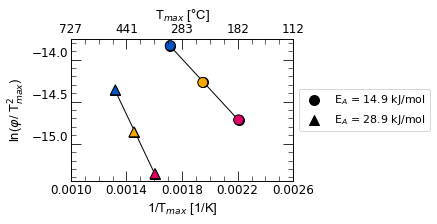

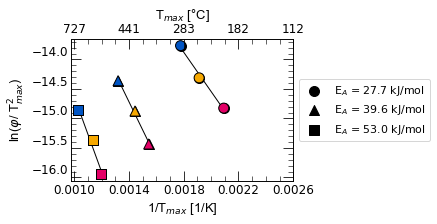

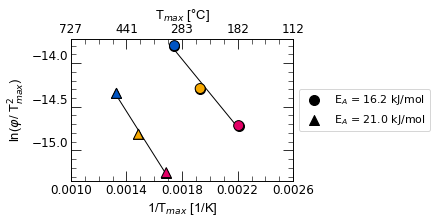

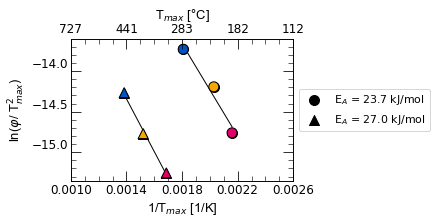

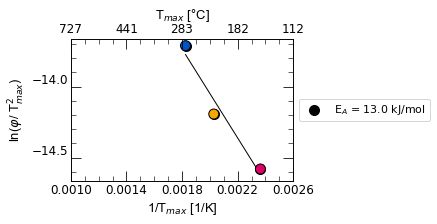

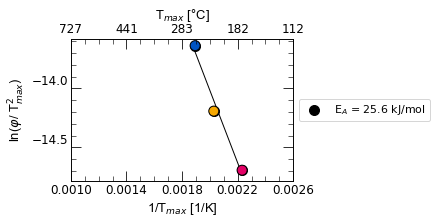

In [175]:
#function for determination of activation energy based on the peakshift due to different heatrates
def arh (group: str) -> None:
    plt.style.use('C:\\Users\\maede\\.matplotlib\\diss_martin_arh.mplstyle')
    #{'H':'#0054c3','M':'#F6A800','L':'#E30066'}
    c=['#0054c3','#F6A800','#E30066']
    peakmarker={'diffpeak':'o','trappeak1':'^','trappeak2':'s'}
    location={'diffpeak':'o','trappeak1':'^','trappeak2':'s'}

    if group[0:3]== 'Q_W':
        peaks=['diffpeak','trappeak1','trappeak2']
    elif group[0]== 'X':
        peaks=['diffpeak','trappeak1']
    elif group[0]== 'S':
        peaks=['diffpeak']
    elif group[0:3]== 'Q_D':
        peaks=['diffpeak','trappeak1']

    measurement=['H'+group,'M'+group,'L'+group]

    fig=plt.figure()
    ax=fig.add_axes([0.20,0.16666667,0.49,0.66666667])
    #color={'H':'#0054c3','M':'#0098a1','L':'#7a6fac'}
    ax.set_prop_cycle(color=c)
    ax2 = ax.twiny()
    for f in peaks:
            #print(f)
            x=[1/(273+getattr(gmeasurements[i],f)) for i in measurement]
            #display(x)
            y=[np.log(gmeasurements[i].heatrate/((273+getattr(gmeasurements[i],f))*(273+getattr(gmeasurements[i],f)))) for i in measurement]
            res=list(np.polyfit(x,y,1))
            func=np.poly1d(res)
            ax.plot(x,func(x),c='black',)
            #f+' '+group+
            ax.scatter(x,y,marker=peakmarker[f],c=c,zorder=2.5)#,label=('Ea = '+str(round((-res[0]*8.3144626*0.001),1))+' kJ/mol'))
            ax.scatter(x,y,marker=peakmarker[f],c='black',zorder=0,label=('E$_A$ = '+str(round((-res[0]*8.3144626*0.001),1))+' kJ/mol'))
            ax.set_xticks(np.arange(.001,.0026001,.0004))
            ax.set_yticks(np.arange(-16,-13.5,.5))
            ax2.set_ylabel('sin')  # we already handled the x-label with ax1
            ax2.scatter(x,y,s=0,c=c,zorder=2.5)

            #loc='upper left' axbox.y0
            axbox = ax.get_position()
            ax.legend(loc='center left', ncol=1,bbox_to_anchor=[0.69,0.5,0,0], bbox_transform=fig.transFigure)
    #labelsnew=['1000','833','714','625','556','500','455','417','385']
    labelsnew=['727','441','283','182','112']
    #labelsnew=['1000','714','556','455','385']
    plt.xticks(np.arange(.001,.0026002,.0004),labelsnew)

    fontproperties = {'font':'Arial','size':13}
    ax.set_ylabel('ln(${\\varphi}$/ T$^{2}_{max}$)',fontproperties)
    ax.set_xlabel('1/T$_{max}$ [1/K]',fontproperties)
    ax2.set_xlabel('T$_{max}$ [°C]',fontproperties)
    plt.show()
    savename=group+'arh.svg'
    fig.savefig(savename,dpi=500)
arh('Q_DRYAIR')
arh('Q_WETAIR')
arh('X_DRYAIR')
arh('X_WETAIR')
arh('S_DRYAIR')
arh('S_WETAIR')

In [176]:
def fill_between_3d(ax,x1,y1,z1,x2,y2,z2,mode=1,c='steelblue',alpha=0.6):
    import numpy as np



    """

    Function similar to the matplotlib.pyplot.fill_between function but
    for 3D plots.

    input:

        ax -> The axis where the function will plot.

        x1 -> 1D array. x coordinates of the first line.
        y1 -> 1D array. y coordinates of the first line.
        z1 -> 1D array. z coordinates of the first line.

        x2 -> 1D array. x coordinates of the second line.
        y2 -> 1D array. y coordinates of the second line.
        z2 -> 1D array. z coordinates of the second line.

    modes:
        mode = 1 -> Fill between the lines using the shortest distance between
                    both. Makes a lot of single trapezoids in the diagonals
                    between lines and then adds them into a single collection.

        mode = 2 -> Uses the lines as the edges of one only 3d polygon.

    Other parameters (for matplotlib):

        c -> the color of the polygon collection.
        alpha -> transparency of the polygon collection.

    """

    if mode == 1:

        for i in range(len(x1)-1):

            verts = [(x1[i],y1[i],z1[i]), (x1[i+1],y1[i+1],z1[i+1])] + \
                    [(x2[i+1],y2[i+1],z2[i+1]), (x2[i],y2[i],z2[i])]

            ax.add_collection3d(Poly3DCollection([verts],
                                                 alpha=alpha,
                                                 linewidths=0,
                                                 color=c))

    if mode == 2:

        verts = [(x1[i],y1[i],z1[i]) for i in range(len(x1))] + \
                [(x2[i],y2[i],z2[i]) for i in range(len(x2))]

        ax.add_collection3d(Poly3DCollection([verts],alpha=alpha,color=c))
def ppms_get (type:str,group:str)-> float:
    lookup=dict(zip(gmeasurements[group].roundtemperature,gmeasurements[group].ppms))
    if type == 'diffpeak':
        return lookup[int(gmeasurements[group].diffpeak)]
    elif type == 'trappeak1':
        return lookup[int(gmeasurements[group].trappeak1)]
    elif type == 'trappeak2':
        return lookup[int(gmeasurements[group].trappeak2)]
    else:
        return 'SHIIIT'

In [177]:


def d3plot_mat(type:str)-> None:
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, projection='3d')
    l=['H','M','L']
    plt.title(type)
    heatsrate={'H':0.3333,'M':0.1666,'L':0.08333}
    color={'H':'#0054c3','M':'#0098a1','L':'#7a6fac'}
    yy, zz = np.meshgrid(np.linspace(0.05,0.44,2576), np.linspace(0,0.00018,1932))
    xx=np.full(yy.shape,0)
    ax.plot_surface(xx,yy,zz, rstride=5, cstride=5,facecolors=np.fliplr(np.flip(plt.imread('data/X80  1000x.jpg')/255.)),  shade=False)
    #ax.plot_surface(xx, yy, zz, rstride=5, cstride=5,facecolors=np.flip(plt.imread('data/X80  1000x.jpg')/255.,0),  shade=False,zorder=0,alpha=0.5)


    for c in l:
         h=c+type
         display(h)

         ax.plot([30,750],[heatsrate[c],heatsrate[c]],[0,0],color=color[c])
         ax.text(750,heatsrate[c],0,str(round(heatsrate[c]*60)),color=color[c],size='30',alpha=1,ha='left',va='center')
         for curve in materials[h]:


             lookup=dict(zip(curve.roundtemperature,curve.ppms))
             xs=mmaterials[h].roundtemperature
             zs=np.full(len(xs),heatsrate[c])
             ys=mmaterials[h].ppms


             set1=[xs,zs,ys]
             set2=[xs,zs+0.0001,pd.Series(xs).map(lookup)]

             fill_between_3d(ax,*set1,*set2,mode=1,alpha=0.5,c=color[c])
         ax.plot(mmaterials[h].roundtemperature,np.full(len(mmaterials[h].roundtemperature),heatsrate[c]),mmaterials[h].ppms,color=color[c],zorder=100,lw=4)


             #ax.plot(curve.roundtemperature,np.full(len(curve.roundtemperature),heatsrate[c]),curve.ppms,color=color[c])



    ax.set_ylim3d(0.01, 0.4)
    ax.set_xlim3d(0.01, 750)
    ax.set_zlim(0.00001, 0.00018)

    ax.view_init(azim=-70,elev=10)
    ax.tick_params(axis='z', which='major', pad=10)
    ax.tick_params(axis='y', which='major', pad=-3, labelrotation=-15)
    #ax.legend(fontsize=30,loc=(15,5), bbox_to_anchor=(0.7,0.55))

    ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.set_yticks([])
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    #ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis._axinfo['juggled'] = (1,2,0)
    ax.grid(False)

    plt.show()
    savename=type+'_mat.svg'
    fig.savefig(savename)

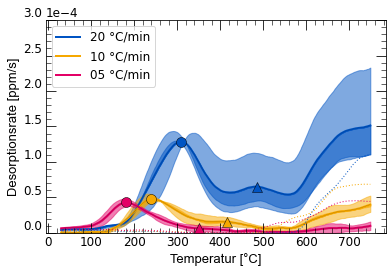

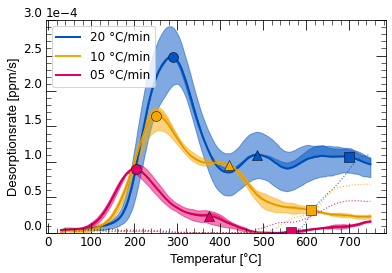

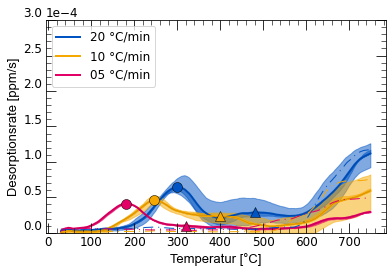

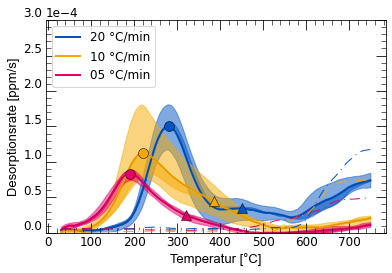

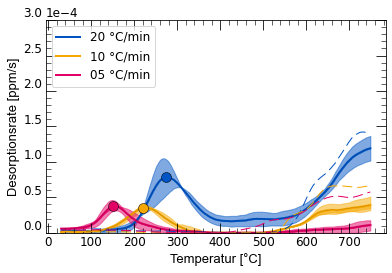

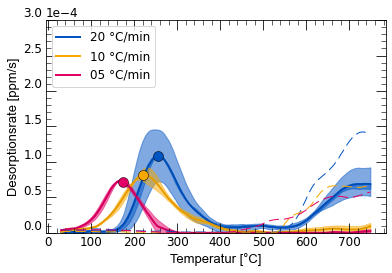

In [178]:
import matplotlib.ticker as mtick
def groupplot(type: str) -> None:
    plt.style.use('C:\\Users\\maede\\.matplotlib\\diss_martin_general.mplstyle')
    fig=plt.figure()
    ax=fig.add_axes([0.132,0.125,0.75,0.75])
    l=['H','M','L']
    stylemap={'Q':':','X':'-.','S':'--'}
    for c in l:
        h=c+type

        ys=gmeasurements[h].ppms
        xs=gmeasurements[h].roundtemperature
        zs=np.full(len(xs),gmeasurements[h].heatrate)

        color={'H':'#0054c3','M':'#F6A800','L':'#E30066'}
        depth={'H':0.01,'M':0.005,'L':0.0025}
        label={'H':'20 °C/min','M':'10 °C/min','L':'05 °C/min'}
        ax.plot(xs, ys, lw=2,color=color[c],zorder=1,label=label[c])
        ax.set_ylim([0,0.0003])
        ax.plot(xs, ys, lw=0.1,color='black',zorder=2)
        ax.plot(xs,gmeasurements[h].matppms,ls=stylemap[type[0]],color=color[c],lw=1)
        for p in range(len(gmeasurements[h].roundtemperaturevectors)): #Error margin in plot

            lookup=dict(zip(gmeasurements[h].roundtemperaturevectors[p],gmeasurements[h].ppmsvectors[p]))
            ax.fill_between(xs,ys,pd.Series(xs).map(lookup),color=color[c],alpha=0.5,zorder=0)
        if type[0:3]== 'Q_W':
            ax.scatter(gmeasurements[h].diffpeak,ppms_get('diffpeak',h),marker='o',facecolor=color[c],linewidths=0.5,alpha=1,zorder=5)
            ax.scatter(gmeasurements[h].trappeak2,ppms_get('trappeak2',h),marker='s',facecolor=color[c],linewidths=0.5,alpha=1,zorder=5)
            ax.scatter(gmeasurements[h].trappeak1,ppms_get('trappeak1',h),marker='^',facecolor=color[c],linewidths=0.5,alpha=1,zorder=5)

        elif type[0]== 'X':

            ax.scatter(gmeasurements[h].diffpeak,ppms_get('diffpeak',h),marker='o',facecolor=color[c],linewidths=0.5,alpha=1,zorder=5)
            ax.scatter(gmeasurements[h].trappeak1,ppms_get('trappeak1',h),marker='^',facecolor=color[c],linewidths=0.5,alpha=1,zorder=5)

        elif type[0]== 'S':


            ax.scatter(gmeasurements[h].diffpeak,ppms_get('diffpeak',h),marker='o',facecolor=color[c],linewidths=0.5,alpha=1,zorder=5)

        elif type[0:3]== 'Q_D':

            ax.scatter(gmeasurements[h].diffpeak,ppms_get('diffpeak',h),marker='o',facecolor=color[c],linewidths=0.5,alpha=1,zorder=5)
            ax.scatter(gmeasurements[h].trappeak1,ppms_get('trappeak1',h),marker='^',facecolor=color[c],linewidths=0.5,alpha=1,zorder=5)
        plt.xticks(np.arange(.001,750,100))
        fontproperties = {'font':'Arial','size':13}
        ax.set_ylabel('Desorptionsrate [ppm/s]',fontproperties)
        ax.set_xlabel('Temperatur [°C]',fontproperties)
        plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        #ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.e'))
        plt.legend()


    plt.show()
    savename=type+'3d.svg'
    fig.savefig(savename,dpi=500)

groupplot('Q_DRYAIR')
groupplot('Q_WETAIR')
groupplot('X_DRYAIR')
groupplot('X_WETAIR')
groupplot('S_DRYAIR')
groupplot('S_WETAIR')

In [179]:
def d3plot(type: str)-> None:



    import matplotlib
    from matplotlib.collections import PolyCollection
    from mpl_toolkits.mplot3d import Axes3D
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, projection='3d')
    l=['H','M','L']


    for c in l:
        h=c+type
        ys=gmeasurements[h].ppms
        xs=gmeasurements[h].roundtemperature
        zs=np.full(len(xs),gmeasurements[h].heatrate)
        ax.plot(xs, zs, ys,lw=0,color='black')
        color={'H':'#0054c3','M':'#0098a1','L':'#7a6fac'}
        depth={'H':0.01,'M':0.005,'L':0.0025}
        label={'H':'20 K/min','M':'10 K/min','L':'05 K/min'}


        for p in range(len(gmeasurements[h].roundtemperaturevectors)): #Error margin in plot

            lookup=dict(zip(gmeasurements[h].roundtemperaturevectors[p],gmeasurements[h].ppmsvectors[p]))



            set1=[xs,zs,ys]
            set2=[xs,zs+0.0001,pd.Series(xs).map(lookup)]

            fill_between_3d(ax,*set1,*set2,mode=1,alpha=0.5,c=color[c])

        plt.title(type)
        ax.plot(xs, zs, ys,lw=4,color=color[c],label=label[c])
        ax.plot(xs, zs, ys,lw=1,color='black')
        ax.plot(xs,zs,gmeasurements[h].matppms,'-.',color=color[c], lw=2.5)
        if type[0]== 'Q':
            ax.set_zlim(0.00001, 0.0003201)
            #ax.plot([gmeasurements[h].diffpeak,gmeasurements[h].diffpeak],[gmeasurements[h].heatrate,0],color=color[c])
            ax.plot([gmeasurements[h].diffpeak,gmeasurements[h].diffpeak],[gmeasurements[h].heatrate,gmeasurements[h].heatrate],[0,ppms_get('diffpeak',h)],'--',color=color[c])
            ax.plot([30,750],[gmeasurements[h].heatrate,gmeasurements[h].heatrate],[0,0],color=color[c])

            #ax.plot([gmeasurements[h].trappeak1,gmeasurements[h].trappeak1],[gmeasurements[h].heatrate,0],color=color[c])
            ax.plot([gmeasurements[h].trappeak1,gmeasurements[h].trappeak1],[gmeasurements[h].heatrate,gmeasurements[h].heatrate],[0,ppms_get('trappeak1',h)],'--',color=color[c])
            #ax.plot([gmeasurements[h].trappeak2,gmeasurements[h].trappeak2],[gmeasurements[h].heatrate,0],color=color[c])
            ax.plot([gmeasurements[h].trappeak2,gmeasurements[h].trappeak2],[gmeasurements[h].heatrate,gmeasurements[h].heatrate],[0,ppms_get('trappeak2',h)],'--',color=color[c])
            ax.text(gmeasurements[h].diffpeak,gmeasurements[h].heatrate,ppms_get('diffpeak',h),'■',color=color[c],size='17',alpha=1,ha='center',va='center')
            ax.text(gmeasurements[h].diffpeak,gmeasurements[h].heatrate,ppms_get('diffpeak',h),'□',color='black',size='17',alpha=0.8,ha='center',va='center')
            ax.text(gmeasurements[h].trappeak2,gmeasurements[h].heatrate,ppms_get('trappeak2',h),'●',color=color[c],size='17',alpha=1,ha='center',va='center')
            ax.text(gmeasurements[h].trappeak2,gmeasurements[h].heatrate,ppms_get('trappeak2',h),'○',color='black',size='17',alpha=0.8,ha='center',va='center')

            ax.text(gmeasurements[h].trappeak1,gmeasurements[h].heatrate,ppms_get('trappeak1',h),'▲',color=color[c],size='17',alpha=1,ha='center',va='center')
            ax.text(gmeasurements[h].trappeak1,gmeasurements[h].heatrate,ppms_get('trappeak1',h),'△',color='black',size='17',alpha=0.8,ha='center',va='center')

            ax.text(750,gmeasurements[h].heatrate,0,str(round(gmeasurements[h].heatrate*60)),color=color[c],size='30',alpha=1,ha='left',va='center')
        elif type[0]== 'X':
            ax.set_zlim(0.00001, 0.0002201)

            #ax.plot([gmeasurements[h].diffpeak,gmeasurements[h].diffpeak],[gmeasurements[h].heatrate,0],color=color[c])
            ax.plot([gmeasurements[h].diffpeak,gmeasurements[h].diffpeak],[gmeasurements[h].heatrate,gmeasurements[h].heatrate],[0,ppms_get('diffpeak',h)],'--',color=color[c])
            ax.plot([30,750],[gmeasurements[h].heatrate,gmeasurements[h].heatrate],[0,0],color=color[c])

            #ax.plot([gmeasurements[h].trappeak1,gmeasurements[h].trappeak1],[gmeasurements[h].heatrate,0],color=color[c])
            ax.plot([gmeasurements[h].trappeak1,gmeasurements[h].trappeak1],[gmeasurements[h].heatrate,gmeasurements[h].heatrate],[0,ppms_get('trappeak1',h)],'--',color=color[c])
            ax.text(gmeasurements[h].diffpeak,gmeasurements[h].heatrate,ppms_get('diffpeak',h),'■',color=color[c],size='17',alpha=0.8,ha='center',va='center')
            ax.text(gmeasurements[h].diffpeak,gmeasurements[h].heatrate,ppms_get('diffpeak',h),'□',color='black',size='17',alpha=0.8,ha='center',va='center')

            ax.text(gmeasurements[h].trappeak1,gmeasurements[h].heatrate,ppms_get('trappeak1',h),'▲',color=color[c],size='17',alpha=0.8,ha='center',va='center')
            ax.text(gmeasurements[h].trappeak1,gmeasurements[h].heatrate,ppms_get('trappeak1',h),'△',color='black',size='17',alpha=0.8,ha='center',va='center')

            ax.text(750,gmeasurements[h].heatrate,0,str(round(gmeasurements[h].heatrate*60)),color=color[c],size='30',alpha=1,ha='left',va='center')
        elif type[0]== 'S':

            ax.set_zlim(0.00001, 0.0001801)
            #ax.plot([gmeasurements[h].diffpeak,gmeasurements[h].diffpeak],[gmeasurements[h].heatrate,0],color=color[c])
            ax.plot([gmeasurements[h].diffpeak,gmeasurements[h].diffpeak],[gmeasurements[h].heatrate,gmeasurements[h].heatrate],[0,ppms_get('diffpeak',h)],'--',color=color[c])
            ax.plot([30,750],[gmeasurements[h].heatrate,gmeasurements[h].heatrate],[0,0],color=color[c])
            ax.text(gmeasurements[h].diffpeak,gmeasurements[h].heatrate,ppms_get('diffpeak',h),'■',color=color[c],size='17',alpha=0.8,ha='center',va='center')
            ax.text(gmeasurements[h].diffpeak,gmeasurements[h].heatrate,ppms_get('diffpeak',h),'□',color='black',size='17',alpha=0.8,ha='center',va='center')

            ax.text(750,gmeasurements[h].heatrate,0,str(round(gmeasurements[h].heatrate*60)),color=color[c],size='30',alpha=1,ha='left',va='center')

    ax.set_ylim3d(0.01, 0.4)
    ax.set_xlim3d(0.01, 750)


    ax.view_init(azim=-70,elev=10)
    ax.tick_params(axis='z', which='major', pad=10)
    ax.tick_params(axis='y', which='major', pad=-3, labelrotation=-15)
    #ax.legend(fontsize=30,loc=(15,5), bbox_to_anchor=(0.7,0.55))

    ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.set_yticks([])
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    #ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis._axinfo['juggled'] = (1,2,0)
    ax.grid(False)

    plt.show()
    savename=type+'3d.svg'
    fig.savefig(savename)
"""d3plot('Q_DRYAIR')
d3plot('Q_WETAIR')
d3plot('X_DRYAIR')
d3plot('X_WETAIR')
d3plot('S_DRYAIR')
d3plot('S_WETAIR')"""


"d3plot('Q_DRYAIR')\nd3plot('Q_WETAIR')\nd3plot('X_DRYAIR')\nd3plot('X_WETAIR')\nd3plot('S_DRYAIR')\nd3plot('S_WETAIR')"

In [180]:
def d3nitplot (type:str)->None:
    """

    :param type: "DRYNIT","WETNIT"
    :return: None
    """
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, projection='3d')
    l=['HQ_','HX_','HS_']
    plt.title(type)
    heatsrate={'HQ_':0.30,'HX_':0.20,'HS_':0.05}



    for c in l:
        h=c+type
        ys=gmeasurements[h].ppms
        xs=gmeasurements[h].roundtemperature
        zs=np.full(len(xs),heatsrate[c])

        ax.plot(xs, zs, ys,lw=0,color='black')
        color={'HQ_':'#0054c3','HX_':'#0054c3','HS_':'#0054c3'}
        depth={'HQ_':0.01,'HX_':0.005,'HS_':0.0025}
        label={'HQ_':'20 K/min','HX_':'10 K/min','HS_':'05 K/min'}
        ax.text(780,heatsrate[c],0,c[1],color=color[c],size='30',alpha=1,ha='left',va='center')
        ax.plot([30,750],[heatsrate[c],heatsrate[c]],[0,0],color=color[c])



        for p in range(len(gmeasurements[h].roundtemperaturevectors)): #Error margin in plot

            lookup=dict(zip(gmeasurements[h].roundtemperaturevectors[p],gmeasurements[h].ppmsvectors[p]))



            set1=[xs,zs,ys]
            set2=[xs,zs+0.0001,pd.Series(xs).map(lookup)]


            fill_between_3d(ax,*set1,*set2,mode=1,alpha=0.5,c=color[c])

        plt.title(type)
        ax.plot(xs, zs, ys,lw=4,color=color[c],label=label[c])
        ax.plot(xs, zs, ys,lw=1,color='black')
        ax.plot(xs,zs,gmeasurements[h].matppms,'-.',color=color[c], lw=2.5)



             #ax.plot(curve.roundtemperature,np.full(len(curve.roundtemperature),heatsrate[c]),curve.ppms,color=color[c])

    ax.set_ylim3d(0.01, 0.4)
    ax.set_xlim3d(0.01, 750)
    #ax.set_zlim(0.00001, 0.00018)

    ax.view_init(azim=-70,elev=10)
    ax.tick_params(axis='z', which='major', pad=10)
    ax.tick_params(axis='y', which='major', pad=-3, labelrotation=-15)
    #ax.legend(fontsize=30,loc=(15,5), bbox_to_anchor=(0.7,0.55))

    ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.set_yticks([])
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    #ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis._axinfo['juggled'] = (1,2,0)
    ax.grid(False)

    plt.show()
    savename=type+'_nit.svg'
    fig.savefig(savename)
"""d3nitplot("WETNIT")
d3nitplot("DRYNIT")"""


'd3nitplot("WETNIT")\nd3nitplot("DRYNIT")'

In [181]:
"""x=gmeasurements['LQ_WETAIR'].roundtemperature
y=[0.083333333,0.1666666666,0.3333333333]
X,Y=np.meshgrid(x,y)
display(np.shape(Y))
z=np.stack([gmeasurements['LQ_WETAIR'].ppms,gmeasurements['MQ_WETAIR'].ppms,gmeasurements['HQ_WETAIR'].ppms])
display(np.shape(z))
display(z)
fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')
trisurf = ax.plot_wireframe(X, Y, z,
                         cmap = 'viridis',
                         linewidth = 0.5,
                         antialiased = True,
                         edgecolor = 'blue')
cset=ax.contourf(X, Y, z, zdir='y', offset=-100,color='black')
fig.colorbar(trisurf, ax = ax, shrink = 0.5, aspect = 5)
ax.view_init(azim=-80,elev=10)
"""


"x=gmeasurements['LQ_WETAIR'].roundtemperature\ny=[0.083333333,0.1666666666,0.3333333333]\nX,Y=np.meshgrid(x,y)\ndisplay(np.shape(Y))\nz=np.stack([gmeasurements['LQ_WETAIR'].ppms,gmeasurements['MQ_WETAIR'].ppms,gmeasurements['HQ_WETAIR'].ppms])\ndisplay(np.shape(z))\ndisplay(z)\nfig = plt.figure(figsize=(15,15))\nax = fig.gca(projection='3d')\ntrisurf = ax.plot_wireframe(X, Y, z,\n                         cmap = 'viridis',\n                         linewidth = 0.5,\n                         antialiased = True,\n                         edgecolor = 'blue')\ncset=ax.contourf(X, Y, z, zdir='y', offset=-100,color='black')\nfig.colorbar(trisurf, ax = ax, shrink = 0.5, aspect = 5)\nax.view_init(azim=-80,elev=10)\n"

In [182]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# create a 513 x 513 vertex mesh

#zz=zz/3125000
# create vertices for a rotated mesh (3D rotation matrix)
def rotate_matrix( m ):
    return [[m[j][i] for j in range(len(m))] for i in range(len(m[0])-1,-1,-1)]

def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(0, height_z, 1932)
    theta = np.linspace(1.1*(np.pi/2), 0.8*np.pi, 2576)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid*0.44/750,z_grid

In [183]:
"""# create the figure
fig = plt.figure(figsize=(15,15))

# show the 3D rotated projection
ax = fig.add_subplot(111, projection='3d')
xx, zz = np.meshgrid(np.linspace(0,2576,2576), np.linspace(0,1932,1932))
X=xx
Z=zz
Y=zz**2
display((plt.imread('data/X80  1000x.jpg')/255.).shape)
ax.plot_surface(*data_for_cylinder_along_z(500,0,750,0.00018), rstride=5, cstride=5,facecolors=np.flip(np.flip(plt.imread('data/X80  1000x.jpg')/255.,0),1),  shade=False)
ax.plot(np.arange(0,750,1),np.full(750,0.33),np.arange(0,0.00018,500))
ax.plot(np.arange(0,750,1),np.full(750,0.11),np.arange(0,0.00018,500))
#ax.plot_surface(xx, yy, zz, rstride=5, cstride=5,facecolors=np.flip(plt.imread('data/X80  1000x.jpg')/255.,0),  shade=False)
"""

"# create the figure\nfig = plt.figure(figsize=(15,15))\n\n# show the 3D rotated projection\nax = fig.add_subplot(111, projection='3d')\nxx, zz = np.meshgrid(np.linspace(0,2576,2576), np.linspace(0,1932,1932))\nX=xx\nZ=zz\nY=zz**2\ndisplay((plt.imread('data/X80  1000x.jpg')/255.).shape)\nax.plot_surface(*data_for_cylinder_along_z(500,0,750,0.00018), rstride=5, cstride=5,facecolors=np.flip(np.flip(plt.imread('data/X80  1000x.jpg')/255.,0),1),  shade=False)\nax.plot(np.arange(0,750,1),np.full(750,0.33),np.arange(0,0.00018,500))\nax.plot(np.arange(0,750,1),np.full(750,0.11),np.arange(0,0.00018,500))\n#ax.plot_surface(xx, yy, zz, rstride=5, cstride=5,facecolors=np.flip(plt.imread('data/X80  1000x.jpg')/255.,0),  shade=False)\n"

In [184]:
"""
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure(figsize=(15,15))

# show the 3D rotated projection
ax = fig.add_subplot(111, projection='3d')


display(X.shape,Y.shape,Z.shape)


plt.show()"""


"\nimport matplotlib.pyplot as plt\nfrom mpl_toolkits.mplot3d import Axes3D\nimport numpy as np\n\nfig = plt.figure(figsize=(15,15))\n\n# show the 3D rotated projection\nax = fig.add_subplot(111, projection='3d')\n\n\ndisplay(X.shape,Y.shape,Z.shape)\n\n\nplt.show()"

In [163]:
"""plt.show()
plt.pcolormesh(X)

plt.colorbar()
plt.show()
plt.pcolormesh(Y)
plt.colorbar()
plt.show()
plt.pcolormesh(Z)
plt.colorbar()
plt.show()"""

'plt.show()\nplt.pcolormesh(X)\n\nplt.colorbar()\nplt.show()\nplt.pcolormesh(Y)\nplt.colorbar()\nplt.show()\nplt.pcolormesh(Z)\nplt.colorbar()\nplt.show()'

In [164]:
"""import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
fig = plt.figure(figsize=(15,15))

# show the 3D rotated projection
ax = fig.add_subplot(111, projection='3d')
xx, zz = np.meshgrid(np.linspace(0,2576,2576), np.linspace(0,2576,2576))
X=xx
Z=zz
Y=np.sqrt((800000000-(zz**2)))
ax.plot_surface((-Z),(Y),(X))
"""

"import matplotlib.pyplot as plt\nfrom mpl_toolkits.mplot3d import Axes3D\nimport numpy as np\nfig = plt.figure(figsize=(15,15))\n\n# show the 3D rotated projection\nax = fig.add_subplot(111, projection='3d')\nxx, zz = np.meshgrid(np.linspace(0,2576,2576), np.linspace(0,2576,2576))\nX=xx\nZ=zz\nY=np.sqrt((800000000-(zz**2)))\nax.plot_surface((-Z),(Y),(X))\n"

In [165]:
def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(0, height_z, 50)
    theta = np.linspace(np.pi/2, np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid*0.44/750,z_grid

In [166]:
"""
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(*data_for_cylinder_along_z(750,0,750,0.00018))
"""

"\nfig = plt.figure(figsize=(15,15))\nax = fig.add_subplot(111, projection='3d')\nax.plot_surface(*data_for_cylinder_along_z(750,0,750,0.00018))\n"

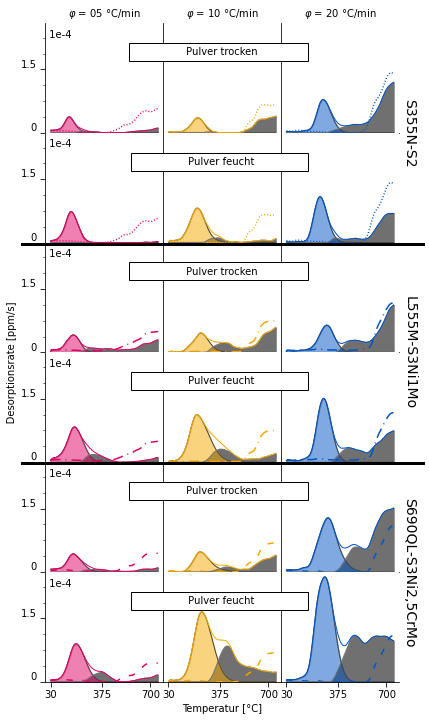

In [167]:
plotlocation=pd.DataFrame({'L':['LS_DRYAIR','LS_WETAIR','LX_DRYAIR','LX_WETAIR','LQ_DRYAIR','LQ_WETAIR'],
                           'M':['MS_DRYAIR','MS_WETAIR','MX_DRYAIR','MX_WETAIR','MQ_DRYAIR','MQ_WETAIR'],
                           'H':['HS_DRYAIR','HS_WETAIR','HX_DRYAIR','HX_WETAIR','HQ_DRYAIR','HQ_WETAIR'],
                           })
plotcolors=pd.DataFrame({'magenta':[['#474747','#E30066','#707070','#E30066'],['#474747','#E30066','#707070','#E30066'],['#474747','#E30066','#707070','#E30066'],['#474747','#E30066','#707070','#E30066'],['#474747','#E30066','#707070','#E30066'],['#474747','#E30066','#707070','#E30066']],
                         'orange':[['#474747','#F6A800','#707070','#F6A800'],['#474747','#F6A800','#707070','#F6A800'],['#474747','#F6A800','#707070','#F6A800'],['#474747','#F6A800','#707070','#F6A800'],['#474747','#F6A800','#707070','#F6A800'],['#474747','#F6A800','#707070','#F6A800']],

                         'blue':[['#474747','#0054c3','#707070','#0054c3'],['#474747','#0054c3','#707070','#0054c3'],['#474747','#0054c3','#707070','#0054c3'],['#474747','#0054c3','#707070','#0054c3'],['#474747','#0054c3','#707070','#0054c3'],['#474747','#0054c3','#707070','#0054c3']],})

plotmarkers=pd.DataFrame({'L':[':',':','-.','-.','--','--'],
                           'M':[':',':','-.','-.','--','--'],
                           'H':[':',':','-.','-.','--','--']})
#'H':'#0054c3','M':'#F6A800','L':'#E30066'

def inch (cm):
    return(cm/2.54)
def diff_trap(ax,type,color,marker):
    f=gmeasurements[type]
    ax.plot(f.roundtemperature,f.diff,label=f.diffppm,c=color[0])
    ax.plot(f.roundtemperature,f.matppms,marker,label='Material_content',c=color[1],lw=1.5)
    ax.plot(f.roundtemperature,f.ppms-f.diff,label='Trap_content',c=color[2])
    ax.fill_between(f.roundtemperature,f.ppms-f.diff,label='Trap_content',color=color[2])
    ax.plot(f.roundtemperature,f.ppms,c=color[3])
    ax.fill_between(f.roundtemperature,f.diff,label=f.diffppm,color=color[3],alpha=0.5)
    #ax.text(400,0.00019,'diff='+str(round(f.diffppm,2)),ha='left',va='top')
    #ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax.set_ylim([0,0.00026])
    ax.set_yticks([0,0.00015])
    ax.set_yticklabels(['0','1.5'],va='bottom')
def meshplot():
    plt.style.use('C:\\Users\\maede\\.matplotlib\\diss_martin_mesh.mplstyle')
    fig,axs=plt.subplots(6,3,figsize=(6.3,9.84), sharex='col', sharey='row',gridspec_kw={'hspace': 0, 'wspace': 0})
    fig.set_constrained_layout
    axn=pd.DataFrame(axs)
    for row in axn.index:
        for col in axn.columns:
            diff_trap(axn.loc[row,col],plotlocation.iloc[row,col],plotcolors.iloc[row,col],plotmarkers.iloc[row,col])

    axn.loc[1,:].apply(lambda x:x.set_xticks([]))
    axn.loc[0,0].set_title('${\\varphi}$ = 05 °C/min')
    axn.loc[0,1].set_title('${\\varphi}$ = 10 °C/min')
    axn.loc[0,2].set_title('${\\varphi}$ = 20 °C/min')
    axn.loc[5,:].apply(lambda x:x.set_xticks([30,375,700]))
    axn.loc[:,0].apply(lambda x:x.text(0,0.000245,' 1e-4   ',rotation=0,zorder=60,va='top',ha='left'))

    axn.loc[:,0].apply(lambda x:x.spines['left'].set_visible(True))
    axn.loc[:,1].apply(lambda x:x.spines['left'].set_visible(True))
    axn.loc[:,2].apply(lambda x:x.spines['left'].set_visible(True))
    axn.loc[5,:].apply(lambda x:x.spines['bottom'].set_visible(True))
    axn.loc[4,:].apply(lambda x:x.spines['bottom'].set_visible(True))
    axn.loc[3,:].apply(lambda x:x.spines['bottom'].set_visible(True))
    axn.loc[2,:].apply(lambda x:x.spines['bottom'].set_visible(True))
    axn.loc[1,:].apply(lambda x:x.spines['bottom'].set_visible(True))
    axn.loc[0,:].apply(lambda x:x.spines['bottom'].set_visible(True))
    axn.loc[:,0].apply(lambda x : x.tick_params(axis='y',which='major',length=5))
    axn.loc[:,0].apply(lambda x : x.tick_params(axis='y',which='minor',length=2))
    axn.loc[5,:].apply(lambda x : x.tick_params(axis='x',which='major',length=5,direction='out'))
    #axn.loc[[0,2,4],0].apply(lambda x : x.set_ylabel('feucht'))
    axn.loc[[0,2,4],2].apply(lambda x : x.text(150,0.00018,'                 Pulver trocken               ',zorder=60,va='bottom',ha='right',bbox={'facecolor':'white','edgecolor':'black','alpha':1}))
    axn.loc[[1,3,5],2].apply(lambda x : x.text(150,0.00018,'                 Pulver feucht                ',zorder=60,va='bottom',ha='right',bbox={'facecolor':'white','edgecolor':'black','alpha':1}))
    axn.loc[1,2].text(900,0.00026,'S355N-S2',rotation=-90,fontsize=14,zorder=60,va='center',ha='right',bbox={'facecolor': 'white','edgecolor':'white','alpha':0})
    axn.loc[3,2].text(900,0.00026,'L555M-S3Ni1Mo',rotation=-90,fontsize=14,zorder=60,va='center',ha='right',bbox={'facecolor': 'white','edgecolor':'white','alpha':0})
    axn.loc[5,2].text(900,0.00026,'S690QL-S3Ni2,5CrMo',rotation=-90,fontsize=14,zorder=60,va='center',ha='right',bbox={'facecolor': 'white','edgecolor':'white','alpha':0})



    axn.loc[3,0].set_ylabel('                             Desorptionsrate [ppm/s]')
    axn.loc[5,1].set_xlabel('Temperatur [°C]')
    axn.loc[2,:].apply(lambda x:x.axhline(0.0002569,-0.2,1.2,lw=3,color='black',clip_on=False,zorder=25))
    axn.loc[4,:].apply(lambda x:x.axhline(0.0002569,-0.2,1.2,lw=3,color='black',clip_on=False,zorder=25))
    #plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

    #display(axn)
    fig.subplots_adjust(bottom=0.05, top=0.98, left=0.15, right=0.93)
    fig.savefig('res_mesh01.svg',dpi=500)
    plt.show()
meshplot()

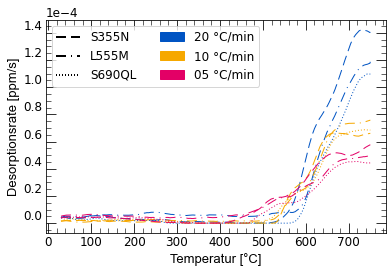

In [185]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
dash_line = mlines.Line2D([], [], color='black', ls='--', label='S355N',lw=2)
dot_line = mlines.Line2D([], [], color='black', ls=':', label='S690QL',lw=2)
dashdot_line = mlines.Line2D([], [], color='black', ls='-.', label='L555M',lw=2)

magenta_patch = mpatches.Patch(color='#E30066', label='05 °C/min')
orange_patch = mpatches.Patch(color='#F6A800', label='10 °C/min')
blue_patch = mpatches.Patch(color='#0054c3', label='20 °C/min')

plt.style.use('C:\\Users\\maede\\.matplotlib\\diss_martin_general.mplstyle')
stylemap={'Q':':','X':'-.','S':'--'}
legend={'HS':'S355N 20 K/min','HQ':'S690QL 20 K/min','HX':'L555M 20 K/min','MS':'S355N 10 K/min',
        'MQ':'S690QL 10 K/min','MX':'L555M   10 K/min','LS':'S355N   5 K/min','LQ':'S690QL  5 K/min','LX':'L555M   5 K/min'}

def matplot (type):
    fig=plt.figure()
    ax=fig.add_axes([0.132,0.125,0.75,0.75])
    for key in mmaterials:
        if key.startswith('H'):

            ax.plot(mmaterials[key].roundtemperature,mmaterials[key].ppms[:],c='#0054c3',ls=stylemap[key[1]],label=legend[key])
        elif key.startswith('M'):
            ax.plot(mmaterials[key].roundtemperature,mmaterials[key].ppms[:],c='#F6A800',ls=stylemap[key[1]],label=legend[key])
        elif key.startswith('L'):
            ax.plot(mmaterials[key].roundtemperature,mmaterials[key].ppms[:],c='#E30066',ls=stylemap[key[1]],label=legend[key])
    axbox = ax.get_position()
    ax.legend(handles=[dash_line,dashdot_line,dot_line,blue_patch,orange_patch,magenta_patch],ncol=2)
    #bbox_to_anchor=[0, axbox.y0-0.28,1,1],
    #ax.legend(loc='upper left', ncol=1, bbox_transform=fig.transFigure)

    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    #ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.e'))
    fontproperties = {'font':'Arial','size':13}
    ax.set_ylabel('Desorptionsrate [ppm/s]',fontproperties)
    ax.set_xlabel('Temperatur [°C]',fontproperties)
    plt.show()
    fig.savefig('matplot_res01.svg',dpi=500)
matplot('type')

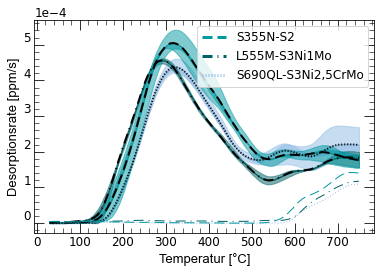

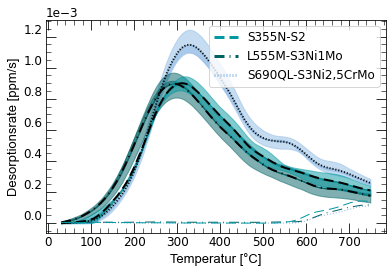

In [186]:
dash_line = mlines.Line2D([], [], color='#0098A1', ls='--', label='S355N-S2',lw=3)
dot_line = mlines.Line2D([], [], color='#8EBAE5', ls=':', label='S690QL-S3Ni2,5CrMo',lw=3)
dashdot_line = mlines.Line2D([], [], color='#006165', ls='-.', label='L555M-S3Ni1Mo',lw=3)
def nitplot(type: str) -> None:
    plt.style.use('C:\\Users\\maede\\.matplotlib\\diss_martin_general.mplstyle')
    fig=plt.figure()
    ax=fig.add_axes([0.132,0.125,0.75,0.75])
    l=['Q','X','S']
    stylemap={'Q':':','X':'-.','S':'--'}
    for c in l:
        h='H'+c+'_'+type

        ys=gmeasurements[h].ppms
        xs=gmeasurements[h].roundtemperature
        zs=np.full(len(xs),gmeasurements[h].heatrate)

        color={'Q':'#8EBAE5','X':'#006165','S':'#0098A1'}
        depth={'H':0.01,'M':0.005,'L':0.0025}
        label={'Q':'Q','X':'X','S':'S'}
        ax.plot(xs, ys, lw=2,color='black',zorder=1,ls=stylemap[c],label=label[c]+' diff '+str(round(gmeasurements[h].diffppm,2))+' ppm')
        #ax.set_ylim([0,0.0003])
        ax.plot(xs, ys, lw=0.1,color='black',zorder=2)
        ax.plot(xs,gmeasurements[h].matppms,ls=stylemap[c],color=color[c],lw=1)
        #ax.text(350,0.0004,gmeasurements[h].diffppm)
        for p in range(len(gmeasurements[h].roundtemperaturevectors)): #Error margin in plot

            lookup=dict(zip(gmeasurements[h].roundtemperaturevectors[p],gmeasurements[h].ppmsvectors[p]))
            ax.fill_between(xs,ys,pd.Series(xs).map(lookup),color=color[c],alpha=0.5,zorder=0)


        fontproperties = {'font':'Arial','size':13}
        ax.set_ylabel('Desorptionsrate [ppm/s]',fontproperties)
        ax.set_xlabel('Temperatur [°C]',fontproperties)



        axbox = ax.get_position()
        ax.legend(loc='lower center', ncol=3,bbox_to_anchor=[0, axbox.y0-0.15,1,1], bbox_transform=fig.transFigure)
        ax.legend(loc='upper right')
        ax.legend(loc='upper right',handles=[dash_line,dashdot_line,dot_line],ncol=1)
        #ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.e'))
        plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.show()
    savename=type+'.svg'
    fig.savefig(savename,dpi=500)

nitplot('DRYNIT')
nitplot('WETNIT')


In [187]:
results=pd.DataFrame({'name':[i for i in gmeasurements],'diffppm':[gmeasurements[i].diffppm for i in gmeasurements],'diffstabw':[gmeasurements[i].diffppmstabw for i in gmeasurements],
                      'trapppm':[gmeasurements[i].trap1ppm for i in gmeasurements],'trapstabw':[gmeasurements[i].trap1ppmstabw for i in gmeasurements],'pppm':[gmeasurements[i].ppm for i in gmeasurements]})
results.set_index('name',inplace=True)

results.to_excel('diff_stabw.xlsx')


In [188]:
mresults=pd.DataFrame({'name':[i for i in measurements],'diffppm':[measurements[i].diffppm for i in measurements],
                      'trapppm':[np.sum(measurements[i].trap1) for i in measurements],'ppm':[measurements[i].ppm for i in measurements]})
mresults.set_index('name',inplace=True)

mresults.to_excel('measurements.xlsx')



In [189]:
display(results.reset_index()[results.reset_index().name.apply(lambda x : x.endswith('Q_WETAIR'))])

,name,diffppm,diffstabw,trapppm,trapstabw,pppm
2,HQ_WETAIR,0.112330,0.019763,0.110829,0.024087,0.223151
13,LQ_WETAIR,0.144082,0.006467,0.058931,0.014674,0.202979
19,MQ_WETAIR,0.153074,0.008856,0.114485,0.010390,0.267540


['S_DRYAIR', 'S_WETAIR', 'X_DRYAIR', 'X_WETAIR', 'Q_DRYAIR', 'Q_WETAIR']

0.03233221219717882+/-0.003524614666660889

0.03640357984833761+/-0.006287644164390865

0.06482778903960772+/-0.00543995687422288

0.016400268755647252+/-0.004477699819182099

0.04029167224118644+/-0.0024555284806681223

0.0625790287764884+/-0.0105385660382136

0.09861978988803027+/-0.015754251501379216

0.04555103285561803+/-0.008513375002743174

0.056869511042192955+/-0.005236859218266743

0.054278713974639625+/-0.015179373687036798

0.1364953579103079+/-0.007533965304273229

0.09474826099606608+/-0.010019319351088712

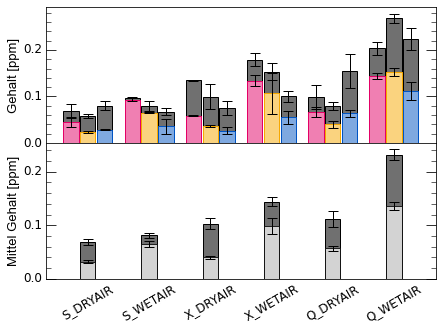

In [190]:
import uncertainties as u
from uncertainties import unumpy as unp

def add_barset(axbot,axtop,diffbar1,trapbar1,diffbar2,trapbar2,diffbar3,trapbar3,diffbackbar,trapbackbar,midpos,differr1,traperr1,differr2,traperr2,differr3,traperr3,trapmeanerr,diffmeanerr):
    diff1=u.ufloat(diffbar1,differr1)
    diff2=u.ufloat(diffbar2,differr2)
    diff3=u.ufloat(diffbar3,differr3)

    trap3=u.ufloat(trapbar3,traperr3)
    trap2=u.ufloat(trapbar2,traperr2)
    trap1=u.ufloat(trapbar1,traperr1)

    diffmean=np.mean([diff1,diff2,diff3])
    trapmean=np.mean([trap1,trap2,trap3])
    display(diffmean,trapmean)

    color={'H':'#7FA9E0','M':'#FAD37F','L':'#F07FB2','MEAN':'#707070'}
    edgecolor={'H':'#0054c3','M':'#F6A800','L':'#E30066','MEAN':'#707070'}
    width=0.5
    edgewidth=1
    ldiff=axtop.bar(midpos-0.55,diffbar1,width=width,zorder=2,color=color['L'],edgecolor=edgecolor['L'],lw=edgewidth,yerr=differr1,capsize=5)
    ltrap=axtop.bar(midpos-0.55,trapbar1+diffbar1,width=width,zorder=1.5,color=color['MEAN'],yerr=traperr1,capsize=5,
                 alpha=1,edgecolor='black',lw=edgewidth)

    mdiff=axtop.bar(midpos,diffbar2,width=width,zorder=2,color=color['M'],edgecolor=edgecolor['M'],lw=edgewidth,yerr=differr2,capsize=5)
    mtrap=axtop.bar(midpos,trapbar2+diffbar2,width=width,zorder=1.5,color=color['MEAN'],yerr=traperr2,capsize=5,
                 alpha=1,edgecolor='black',lw=edgewidth)

    hdiff=axtop.bar(midpos+0.55,diffbar3,width=width,zorder=2,color=color['H'],edgecolor=edgecolor['H'],lw=edgewidth,yerr=differr3,capsize=5)
    htrap=axtop.bar(midpos+0.55,trapbar3+diffbar3,width=width,zorder=1.5,color=color['MEAN'],yerr=traperr3,capsize=5,
                 alpha=1,edgecolor='black',lw=1)
    """htrap=axtop.bar(midpos+0.55,trapbar3+diffbar3,width=width,zorder=1.5,facecolor='none',
                 alpha=1,edgecolor='black',lw=0.1)"""


    """meandiffbar=axbot.hlines(diffbackbar,midpos-0.75,midpos+0.75,lw=3,color='black',zorder=7)
    meandiffbar=axbot.hlines(diffbackbar+trapbackbar,midpos-0.75,midpos+0.75,lw=3,color='black',zorder=7)
    meandiff=axbot.bar(midpos,diffbackbar,width=1.5,zorder=6,color='#484848',hatch='//',
                    edgecolor='grey',facecolor='none')
    meandiff=axbot.bar(midpos,diffbackbar,width=1.5,zorder=8,edgecolor='black',facecolor='none')
    meantrap=axbot.bar(midpos,trapbackbar+diffbackbar,width=1.5,zorder=5.5,color='#808080',hatch='/',edgecolor='black',facecolor='none',lw=3)
    """
    meanoverlaydiff=axbot.bar(midpos-0.55,trapbackbar+diffbackbar,width=width,zorder=5.5,facecolor='none')
    meanoverlaydiff=axbot.bar(midpos+0.55,trapbackbar+diffbackbar,width=width,zorder=5.5,facecolor='none')

    meanoverlaydiff=axbot.bar(midpos,trapbackbar+diffbackbar,width=width,zorder=5.5,color=color['MEAN'],edgecolor='black',lw=edgewidth,yerr=trapmean.s,capsize=5)


    meanoverlaytrap=axbot.bar(midpos,diffbackbar,width=width,zorder=5.5,color='lightgrey',edgecolor='black',lw=0.8,yerr=diffmean.s,capsize=5)

    """meanoverlaytrap=axbot.bar(midpos,diffbackbar,width=width,zorder=5.5,color='lightgrey',edgecolor='black',lw=0.1)"""

def barplot(results):
    color={'H':'#8EBAE5','M':'#0098a1','L':'#7a6fac'}
    plt.style.use('C:\\Users\\maede\\.matplotlib\\diss_martin_stackedbarplot.mplstyle')
    positions= {0:1,1:3,2:5,3:7,4:9,5:11}
    groups=['S_DRYAIR','S_WETAIR',
            'X_DRYAIR','X_WETAIR',
            'Q_DRYAIR','Q_WETAIR']
    display(groups)
    fig=plt.figure()
    grid = plt.GridSpec(2, 1, hspace=0, wspace=0)
    topax=fig.add_subplot(grid[0,:])
    botax=fig.add_subplot(grid[1:,:])


    for i,group in enumerate(groups):
        data=results.reset_index()[results.reset_index().name.apply(lambda x : x.endswith(group))]
        add_barset(botax,topax,data.iloc[1,:]['diffppm'],data.iloc[1,:]['trapppm'],data.iloc[2,:]['diffppm'],
                   data.iloc[2,:]['trapppm'],data.iloc[0,:]['diffppm'],data.iloc[0,:]['trapppm'],
                   data.diffppm.mean(),data.trapppm.mean(),positions[i],
                   data.iloc[1,:]['diffstabw'],data.iloc[1,:]['trapstabw'],data.iloc[2,:]['diffstabw'],
                   data.iloc[2,:]['trapstabw'],data.iloc[0,:]['diffstabw'],data.iloc[0,:]['trapstabw']
                   ,np.std(data.trapppm),np.std(data.diffppm))
    botax.set_xticks(list(positions.values()))
    botax.set_xticklabels(groups,rotation=30)
    botax.set_yticks(np.arange(0,0.2001,0.1))
    for label in botax.yaxis.get_ticklabels():
        label.set_verticalalignment('center')
    topax.set_yticks(np.arange(0,0.2501,0.1))
    #topax.set_yticklabels(['0.00','0.10','0.20'])
    for label in topax.yaxis.get_ticklabels():
        label.set_verticalalignment('center')
    fontproperties = {'font':'Arial','size':13}
    topax.set_ylabel('Gehalt [ppm]',fontproperties)
    botax.set_ylabel('Mittel Gehalt [ppm]',fontproperties)
    #ax.set_xlabel('Temperatur [°C]',fontproperties)
    plt.show()
    fig.savefig('stacked_mean_2.svg',dpi=500,bbox_inches='tight')



barplot(results)